In [25]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from models import BFDataset, VAE, BFVAE
from MMD_func import MMD_U as MMD
rng = np.random.default_rng()

In [26]:
# import training and test data
path = '../MonteCarlo/burgers-4.npz'
file = np.load(path)
LF, HF = file['yL'], file['yH']

xL_trn = torch.from_numpy(LF[:4000]).type(torch.FloatTensor)
xL = torch.from_numpy(LF[:8000]).type(torch.FloatTensor)
xH = torch.from_numpy(HF[:8000]).type(torch.FloatTensor)
xH_tst = torch.from_numpy(HF[8000: 9000]).type(torch.FloatTensor)

In [27]:
## Universal hyper-para
_,input_dim = xH_tst.shape
batch_size = 64
tst_size = 1000
mmd_para = [0.2, 0.5, 1.0, 2.0, 5.0]
latent_dim = 4
hidden_dims = [128, 64, 16]
beta = 0.5
num_trial = 5
hf_size_lst = [2, 3, 4, 5, 7, 8, 10, 50, 100, 1000]


# claim and train lf-vae
lfvae_model = VAE(input_dim, latent_dim, hidden_dims, beta)
lfvae_loss = lfvae_model.train(xL_trn, epochs=2000)

100%|██████████| 2000/2000 [09:50<00:00,  3.39 Epoch/s, loss=-11.479053] 


In [28]:
hf_mmd_lst, bf_mmd_lst = [], []
for hf_size in hf_size_lst:
    hf_mmd, bf_mmd = [], []
    for _ in range(num_trial):      
        # claim and train hf-vae
        hf_trn_idx = rng.choice(8000, hf_size, replace=False)
        hf_trn_data = xH[hf_trn_idx]
        hfvae_model = VAE(input_dim, latent_dim, hidden_dims, beta)
        hfvae_loss = hfvae_model.train(hf_trn_data, epochs=1000)

        # claim and train bf-vae
        hf_trn_data = xH[hf_trn_idx]
        lf_trn_data = xL[hf_trn_idx]
        bf_trn_data = BFDataset(lf_trn_data, hf_trn_data)
        bfvae_model = BFVAE(lfvae_model)
        bfvae_loss = bfvae_model.train(bf_trn_data, epochs=1000)

        ## Compute MMD result
        # HF-VAE
        hf_gen = hfvae_model.sample(1000)
        hf_mmd.append(MMD(hf_gen, xH_tst, mmd_para)) 

        # BF-VAE
        bf_gen = bfvae_model.sample(1000)
        bf_mmd.append(MMD(bf_gen, xH_tst, mmd_para)) 
        
    hf_mmd_lst.append(hf_mmd)
    bf_mmd_lst.append(bf_mmd)

100%|██████████| 1000/1000 [00:33<00:00, 29.42 Epoch/s, loss=0.00050315954]


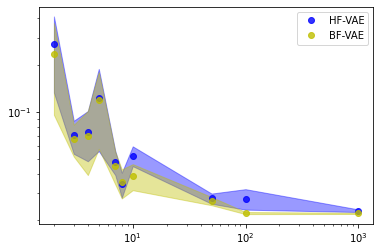

In [32]:
scale = 0.5
hf_mean, bf_mean = np.mean(hf_mmd_lst, axis=1), np.mean(bf_mmd_lst, axis=1)
hf_std, bf_std = np.std(hf_mmd_lst, axis=1), np.std(bf_mmd_lst, axis=1)
plt.plot(hf_size_lst, hf_mean, 'o' ,c='b', label='HF-VAE', alpha=0.8)
plt.fill_between(hf_size_lst, hf_mean - scale * hf_std, hf_mean + scale * hf_std, color='b', alpha=0.4)
plt.plot(hf_size_lst, bf_mean, 'o' ,c='y', label='BF-VAE', alpha=0.8)
plt.fill_between(hf_size_lst, bf_mean - scale * bf_std, bf_mean + scale * bf_std, color='y', alpha=0.4)
plt.legend()
plt.xscale('log')
plt.yscale('log')